# Spotify Song Popularity: Clustering Analysis

## Navigation
- [Setup & Data Loading](#setup)
- [Optimal Cluster Selection](#optimal-clusters)
- [K-Means Clustering (k=6)](#kmeans-analysis)
- [Hierarchical Clustering](#hierarchical)
- [PCA Visualization](#pca)
- [Cluster Interpretation](#interpretation)
- [Key Findings](#findings)

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Load Cleaned Data

In [2]:
# Load log-transformed data using utility module
sys.path.append('../src')
from data_loader import load_log_transformed_data

log_df = load_log_transformed_data()

## Prepare Data for Clustering

In [3]:
# Select only numeric features (exclude target variable)
input_features = log_df.select_dtypes('number').drop(columns=['pop_log']).copy()

# Standardize features (required for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(input_features)

print(f"Features for clustering: {input_features.columns.tolist()}")
print(f"Scaled data shape: {X_scaled.shape}")

Features for clustering: ['danceability', 'energy', 'loudness', 'valence', 'tempo', 'duration_ms', 'speechiness_log', 'acousticness_log', 'instrumentalness_log', 'liveness_log']
Scaled data shape: (25190, 10)


## Optimal Cluster Selection

### Elbow Method for K-Means

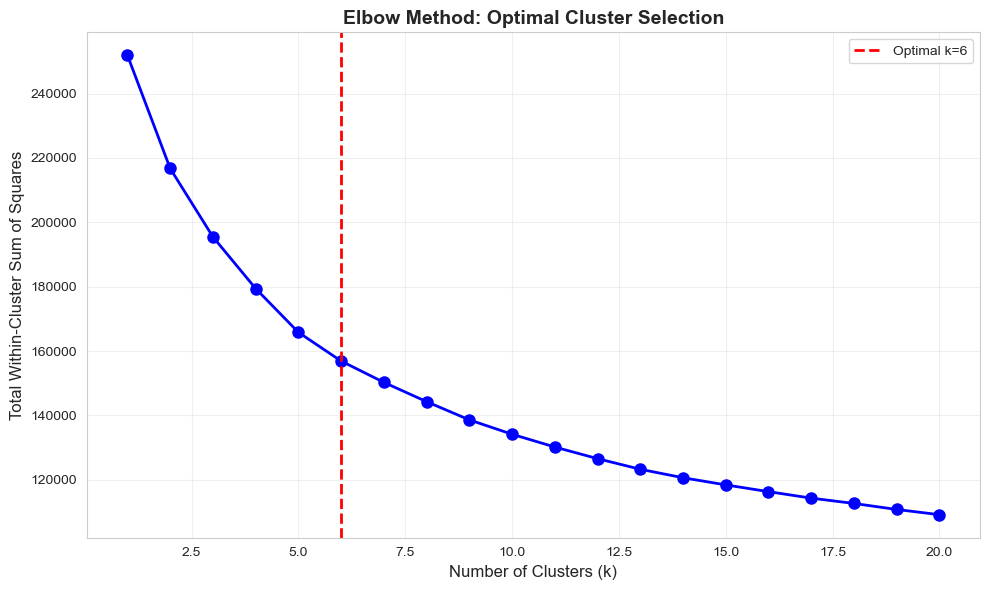

CPU times: user 3min 2s, sys: 6min 38s, total: 9min 41s
Wall time: 59.9 s


In [4]:
%%time

# Test k=1 to k=20
K_range = range(1, 21)
inertias = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=121, n_init=25, max_iter=500)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax.set_xlabel('Number of Clusters (k)', fontsize=12)
ax.set_ylabel('Total Within-Cluster Sum of Squares', fontsize=12)
ax.set_title('Elbow Method: Optimal Cluster Selection', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
ax.axvline(x=6, color='red', linestyle='--', linewidth=2, label='Optimal k=6')
ax.legend()
plt.tight_layout()
plt.show()

**Observation:** 
The elbow appears at **k=6**, where the rate of decrease in inertia significantly slows. We'll use k=6 for detailed analysis.

## K-Means Clustering (k=6)

### Fit K-Means Model

In [5]:
#Fit K-Means with k=6
kmeans_6 = KMeans(n_clusters=6, random_state=121, n_init=25, max_iter=500)
cluster_labels = kmeans_6.fit_predict(X_scaled)

# Add cluster labels to dataframe
log_df['cluster_k6'] = pd.Series(cluster_labels, index=log_df.index).astype('category')

print(f"Cluster distribution:")
print(log_df['cluster_k6'].value_counts().sort_index())

### Cluster Characteristics Heatmap

# Calculate mean values for each cluster
cluster_means = log_df.groupby('cluster_k6').mean(numeric_only=True)

# Standardize for better visualization
cluster_means_scaled = StandardScaler().fit_transform(cluster_means)
cluster_means_scaled = pd.DataFrame(
    cluster_means_scaled, 
    columns=cluster_means.columns,
    index=cluster_means.index
)

Cluster distribution:
cluster_k6
0    5599
1    7391
2    2688
3    3548
4    2243
5    3721
Name: count, dtype: int64


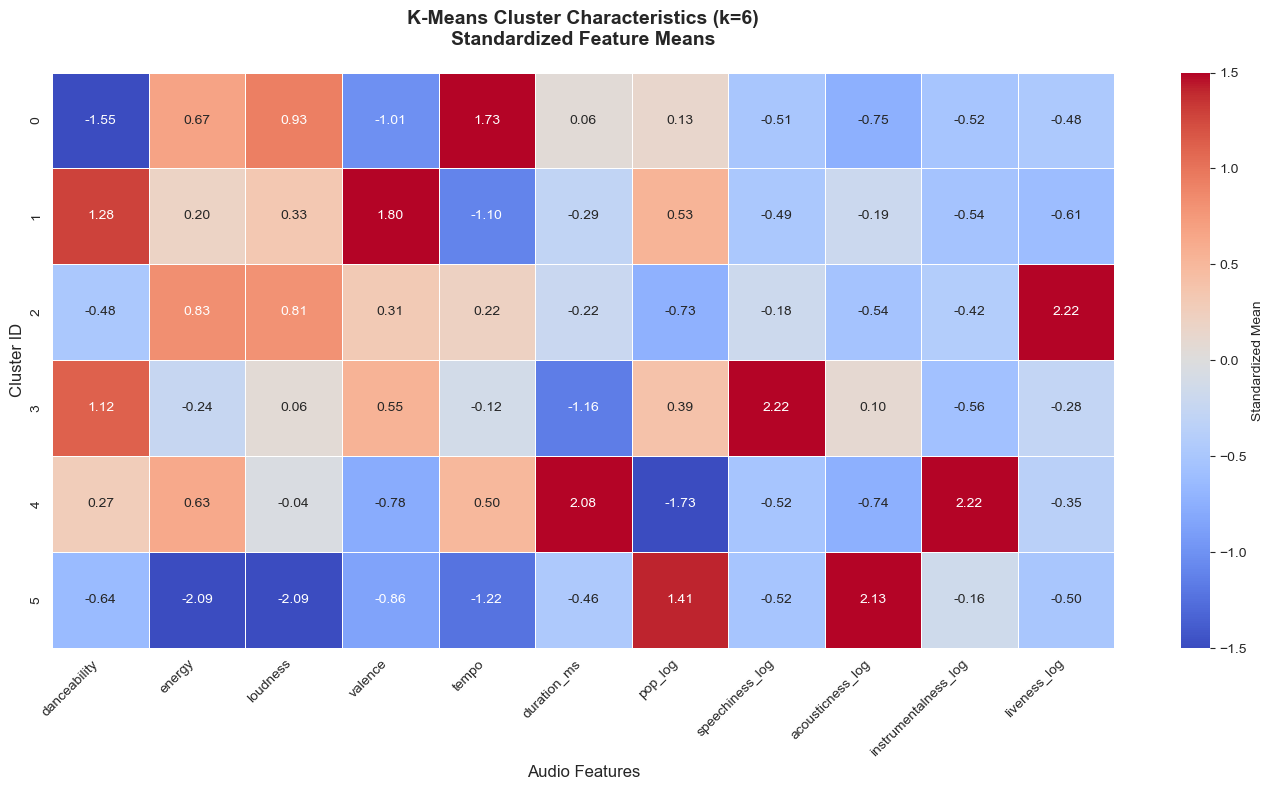

In [6]:
# Create heatmap
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(
    cluster_means_scaled,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    vmin=-1.5,
    vmax=1.5,
    cbar_kws={'label': 'Standardized Mean'},
    linewidths=0.5,
    ax=ax
)
ax.set_title('K-Means Cluster Characteristics (k=6)\nStandardized Feature Means', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_ylabel('Cluster ID', fontsize=12)
ax.set_xlabel('Audio Features', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [7]:
# Show actual (non-standardized) values
print("\nCluster Feature Means (Actual Values):")
print(cluster_means.round(2))


Cluster Feature Means (Actual Values):
            danceability  energy  loudness  valence   tempo  duration_ms  \
cluster_k6                                                                 
0                   0.54    0.79     -5.42     0.37  134.19    229305.44   
1                   0.74    0.72     -6.47     0.69  113.38    225009.61   
2                   0.61    0.81     -5.64     0.52  123.07    225868.57   
3                   0.73    0.66     -6.94     0.55  120.63    214319.78   
4                   0.67    0.78     -7.12     0.40  125.17    254194.25   
5                   0.60    0.42    -10.70     0.39  112.50    222942.01   

            pop_log  speechiness_log  acousticness_log  instrumentalness_log  \
cluster_k6                                                                     
0             -1.20             0.07              0.06                  0.02   
1             -1.10             0.07              0.13                  0.01   
2             -1.43            

## Cluster Interpretations

**Cluster 0 - Energetic Dance/R&B:**
- Key features: Energy (0.66), danceability (0.62), valence (0.62)
- Older tracks (mean year: 1987)
- Mean popularity: **-1.07** (3rd highest)

**Cluster 1 - Acoustic/Chill (MOST POPULAR):**
- Key features: Low energy (0.42), high acousticness_log (0.43), low loudness (-10.28 dB)
- Lower valence (0.37) - more melancholic
- Mean popularity: **-0.85** (HIGHEST) ✓

**Cluster 2 - High Energy, Low Danceability:**
- Key features: Highest energy (0.81), lowest danceability (0.54), high tempo (132 BPM)
- Live performances (liveness_log: 0.22)
- Mean popularity: **-1.31** (5th)

**Cluster 3 - Spoken Word/Rap:**
- Key features: Very high speechiness_log (0.27), high danceability (0.72)
- Moderate valence (0.55)
- Mean popularity: **-1.23** (4th)

**Cluster 4 - Instrumental/EDM (LEAST POPULAR):**
- Key features: Extremely high instrumentalness_log (0.54), longest duration (254 sec)
- Low valence (0.39)
- Mean popularity: **-1.76** (LOWEST) ✓

**Cluster 5 - Feel-Good Pop:**
- Key features: Highest valence (0.65), high danceability (0.74)
- High energy (0.73), moderate tempo (115 BPM)
- Mean popularity: **-1.07** (tied for 3rd)

## Cluster vs Genre Comparison

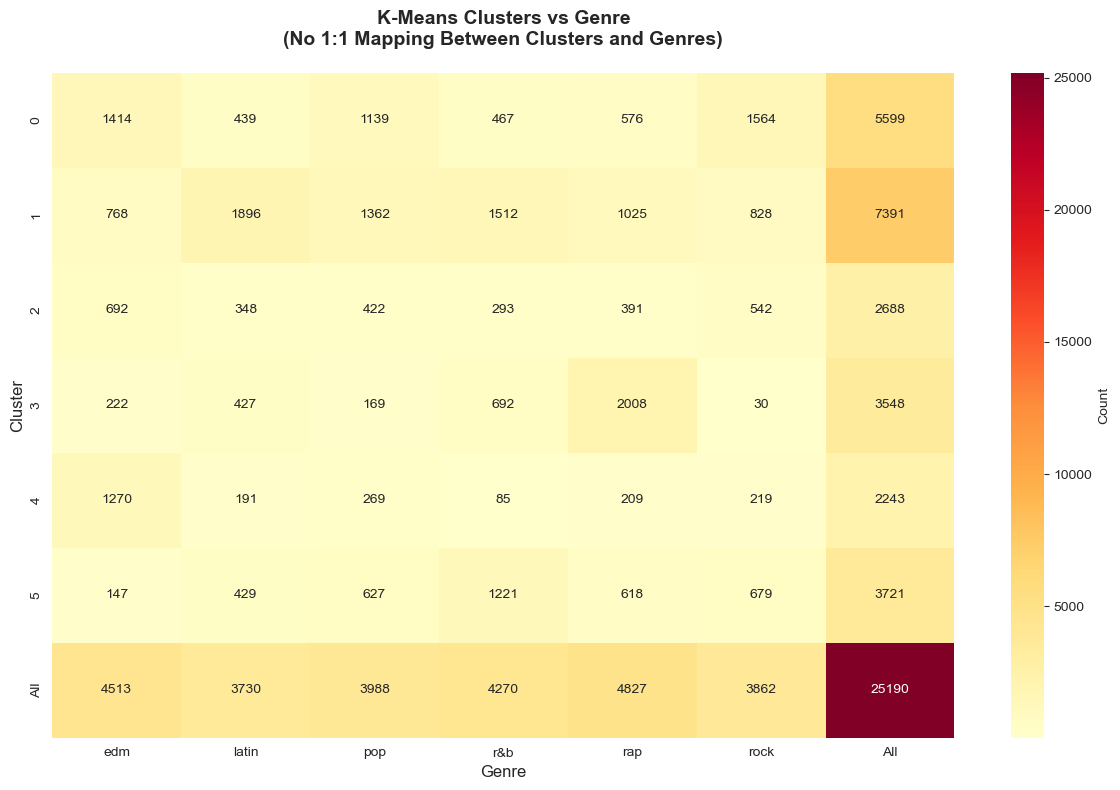

In [8]:
# Cross-tabulation
cluster_genre_crosstab = pd.crosstab(
    log_df['cluster_k6'], 
    log_df['playlist_genre'],
    margins=True
)

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(
    cluster_genre_crosstab,
    annot=True,
    fmt='g',
    cmap='YlOrRd',
    cbar_kws={'label': 'Count'},
    ax=ax
)
ax.set_title('K-Means Clusters vs Genre\n(No 1:1 Mapping Between Clusters and Genres)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_ylabel('Cluster', fontsize=12)
ax.set_xlabel('Genre', fontsize=12)
plt.tight_layout()
plt.show()

**Key Finding:**
> Clusters do NOT align with genres. Each cluster contains songs from multiple genres, suggesting that Spotify's genre labels don't capture the acoustic feature space well.

### Do Clusters Predict Popularity?

/var/folders/zg/x39zyt355fqdhv39xqml_nsh0000gn/T/ipykernel_22627/4054809323.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


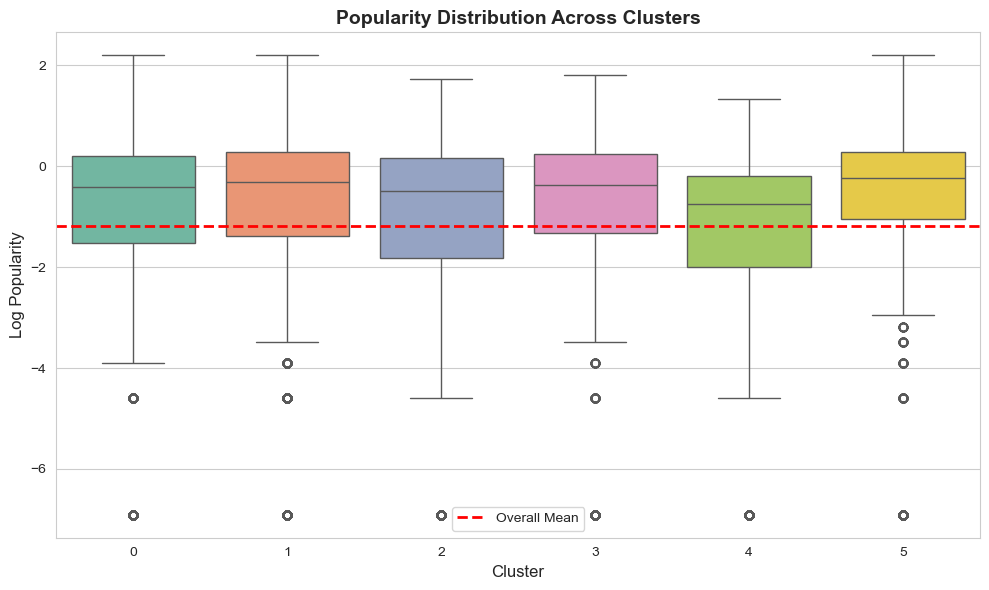

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    data=log_df,
    x='cluster_k6',
    y='pop_log',
    palette='Set2',
    ax=ax
)
ax.set_title('Popularity Distribution Across Clusters', fontsize=14, fontweight='bold')
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Log Popularity', fontsize=12)
ax.axhline(y=log_df['pop_log'].mean(), color='red', linestyle='--', 
           linewidth=2, label='Overall Mean')
ax.legend()
plt.tight_layout()
plt.show()

In [10]:
# Statistical comparison
cluster_pop_stats = log_df.groupby('cluster_k6')['pop_log'].agg(['mean', 'median', 'std', 'count'])
print("\nPopularity Statistics by Cluster:")
print(cluster_pop_stats.sort_values('mean', ascending=False))


Popularity Statistics by Cluster:
                mean    median       std  count
cluster_k6                                     
5          -0.868366 -0.241162  1.979280   3721
1          -1.097361 -0.322773  2.215062   7391
3          -1.135476 -0.363965  2.267391   3548
0          -1.201719 -0.405465  2.261414   5599
2          -1.427682 -0.489548  2.446678   2688
4          -1.687871 -0.753772  2.281579   2243


**Critical Finding:**
> Clusters show **minimal separation in popularity**. All cluster medians overlap heavily, with IQRs spanning similar ranges. Cluster 1 (Acoustic/Chill) is slightly more popular.

**Conclusion:** While clusters successfully group songs by audio features, they do NOT predict popularity differences.


## PCA Visualization

### Reduce Dimensionality

In [11]:
# Apply PCA to visualize high-dimensional clusters
pca = PCA(n_components=2, random_state=121)
pca_coords = pca.fit_transform(X_scaled)

# Create PCA dataframe
pca_df = pd.DataFrame(
    pca_coords,
    columns=['PC1', 'PC2']
)
pca_df['kmeans_k6'] = log_df['cluster_k6']
pca_df['pop_log'] = log_df['pop_log']
pca_df['genre'] = log_df['playlist_genre'].values

print(f"Variance explained by PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"Variance explained by PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")


Variance explained by PC1: 21.73%
Variance explained by PC2: 15.53%
Total variance explained: 37.26%


### Visualize Clusters in PCA Space

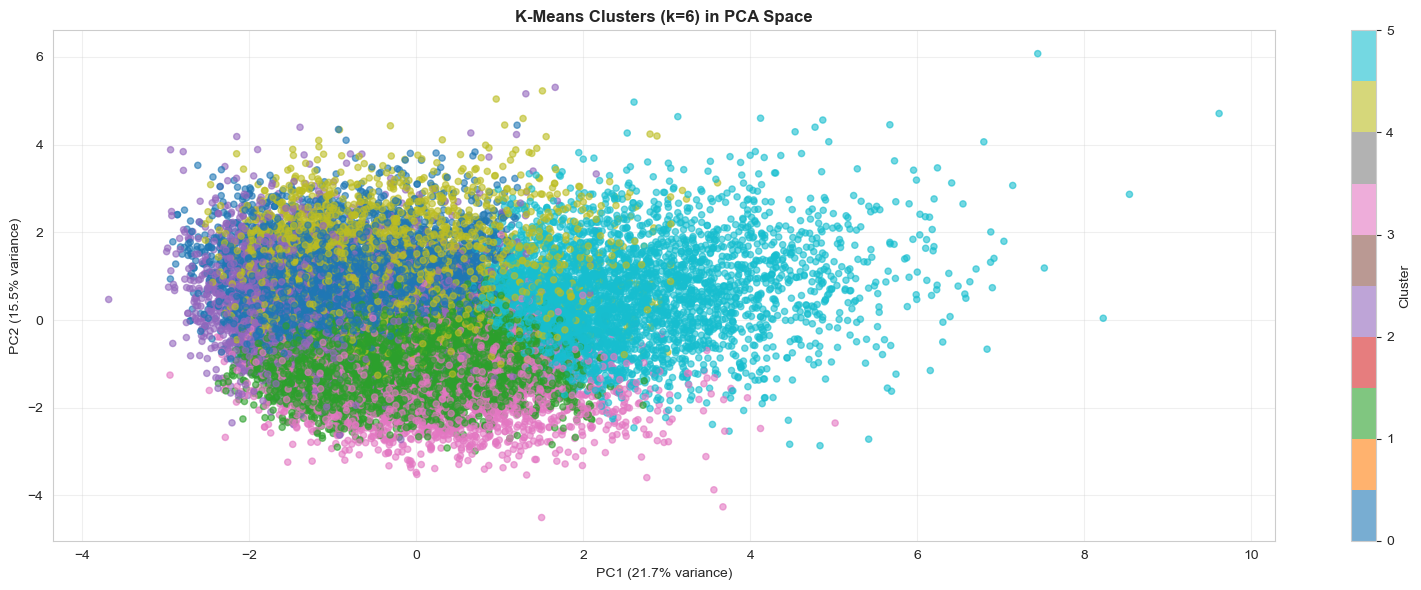

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))

# K-Means clusters
scatter1 = ax.scatter(
    pca_df['PC1'], 
    pca_df['PC2'],
    c=pca_df['kmeans_k6'].astype(int),
    cmap='tab10',
    alpha=0.6,
    s=20
)
ax.set_title('K-Means Clusters (k=6) in PCA Space', fontsize=12, fontweight='bold')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=10)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=10)
ax.grid(alpha=0.3)
plt.colorbar(scatter1, ax=ax, label='Cluster')

plt.tight_layout()
plt.show()

**Observation:** Clustering methods separate songs in feature space, but with significant overlap. No clear, distinct clusters emerge.

### Popularity in PCA Space

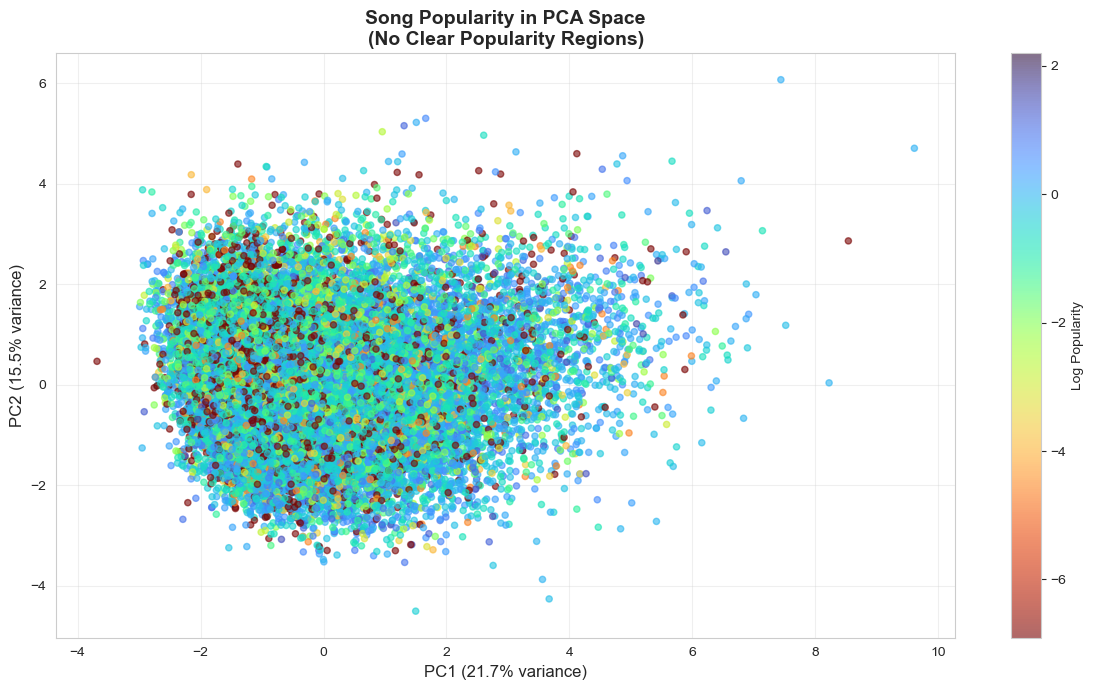

In [13]:
fig, ax = plt.subplots(figsize=(12, 7))

scatter = ax.scatter(
    pca_df['PC1'],
    pca_df['PC2'],
    c=pca_df['pop_log'],
    cmap='turbo_r',
    alpha=0.6,
    s=20
)
ax.set_title('Song Popularity in PCA Space\n(No Clear Popularity Regions)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Log Popularity')
plt.tight_layout()
plt.show()

**Critical Finding:**
> Popularity is **randomly distributed** across the PCA space. There are no "popular" or "unpopular" regions, confirming that audio features don't cluster by popularity.

## Cluster Interpretation

### Feature Importance by Cluster

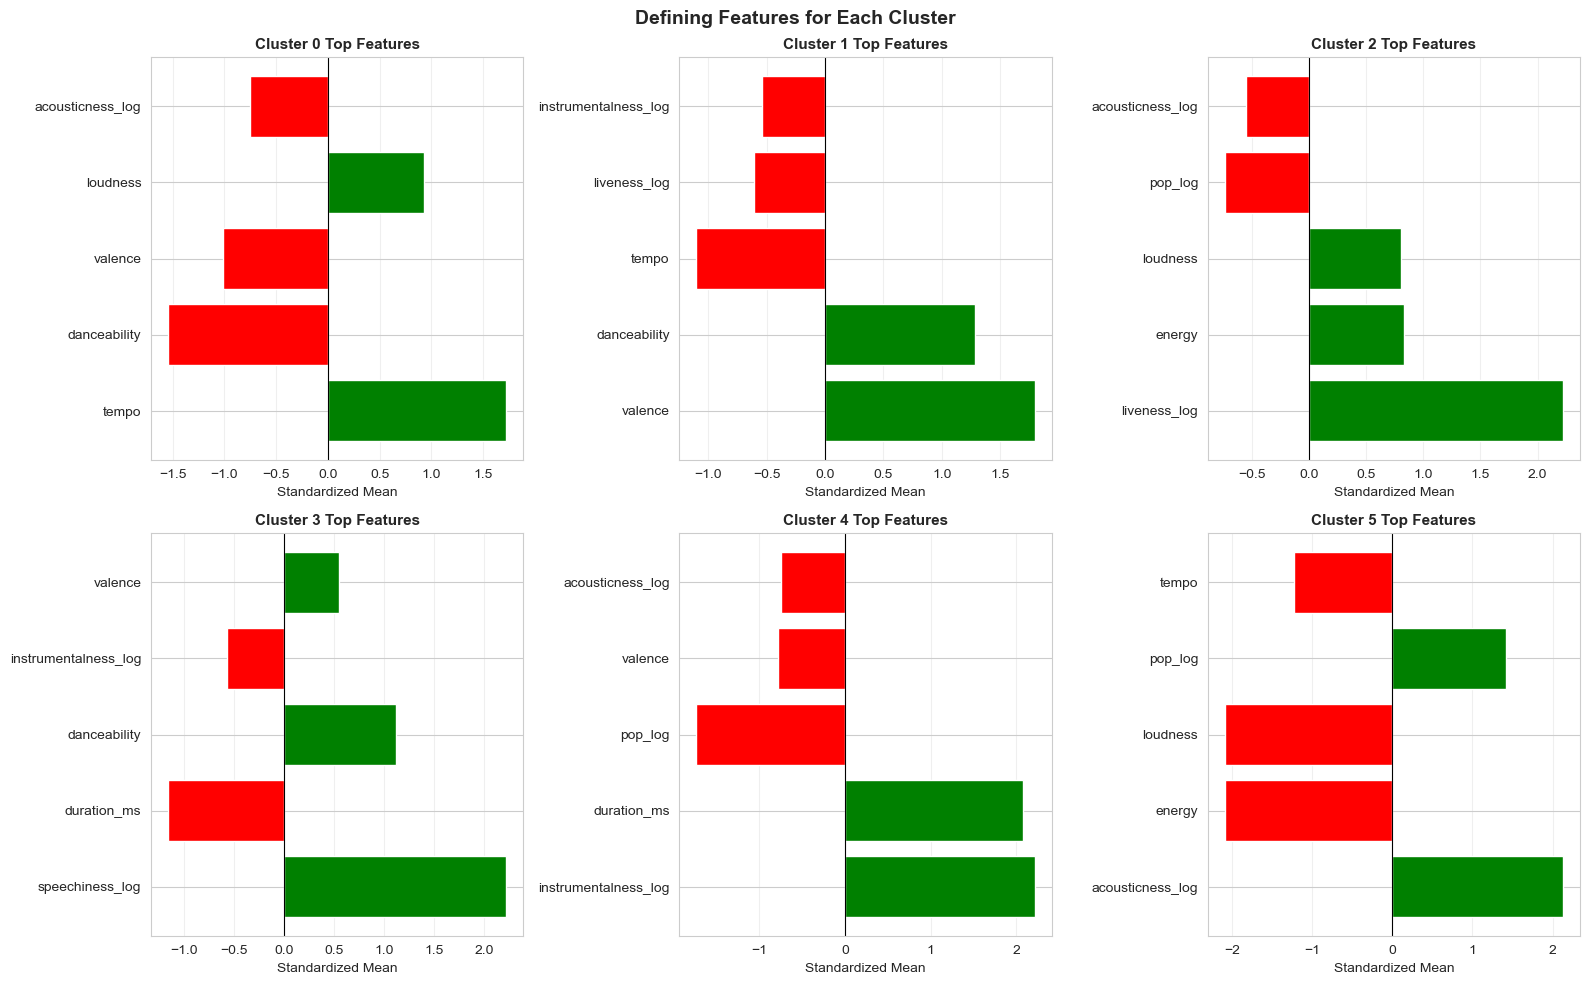

In [14]:
# Show which features define each cluster most strongly
feature_names = input_features.columns.tolist()

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for cluster_id in range(6):
    cluster_data = cluster_means_scaled.loc[cluster_id]
    
    # Sort by absolute value
    sorted_features = cluster_data.abs().sort_values(ascending=False).head(5)
    
    colors = ['red' if cluster_data[feat] < 0 else 'green' for feat in sorted_features.index]
    
    axes[cluster_id].barh(sorted_features.index, cluster_data[sorted_features.index], color=colors)
    axes[cluster_id].set_title(f'Cluster {cluster_id} Top Features', fontsize=11, fontweight='bold')
    axes[cluster_id].set_xlabel('Standardized Mean', fontsize=10)
    axes[cluster_id].axvline(x=0, color='black', linewidth=0.8)
    axes[cluster_id].grid(alpha=0.3, axis='x')

plt.suptitle('Defining Features for Each Cluster', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### Cluster Popularity Comparison

In [15]:
# Create summary table
cluster_summary = pd.DataFrame({
    'Cluster': range(6),
    'Description': [
        'Energetic Dance/R&B',
        'Acoustic/Chill',
        'High Energy/Live',
        'Spoken Word/Rap',
        'Instrumental/EDM',
        'Feel-Good Pop'
    ],
    'Mean Popularity': cluster_means['pop_log'].values,
    'Size': log_df['cluster_k6'].value_counts().sort_index().values
})

cluster_summary = cluster_summary.sort_values('Mean Popularity', ascending=False)
print("\nCluster Summary (Ranked by Popularity):")
print(cluster_summary.to_string(index=False))


Cluster Summary (Ranked by Popularity):
 Cluster         Description  Mean Popularity  Size
       5       Feel-Good Pop        -0.868366  3721
       1      Acoustic/Chill        -1.097361  7391
       3     Spoken Word/Rap        -1.135476  3548
       0 Energetic Dance/R&B        -1.201719  5599
       2    High Energy/Live        -1.427682  2688
       4    Instrumental/EDM        -1.687871  2243


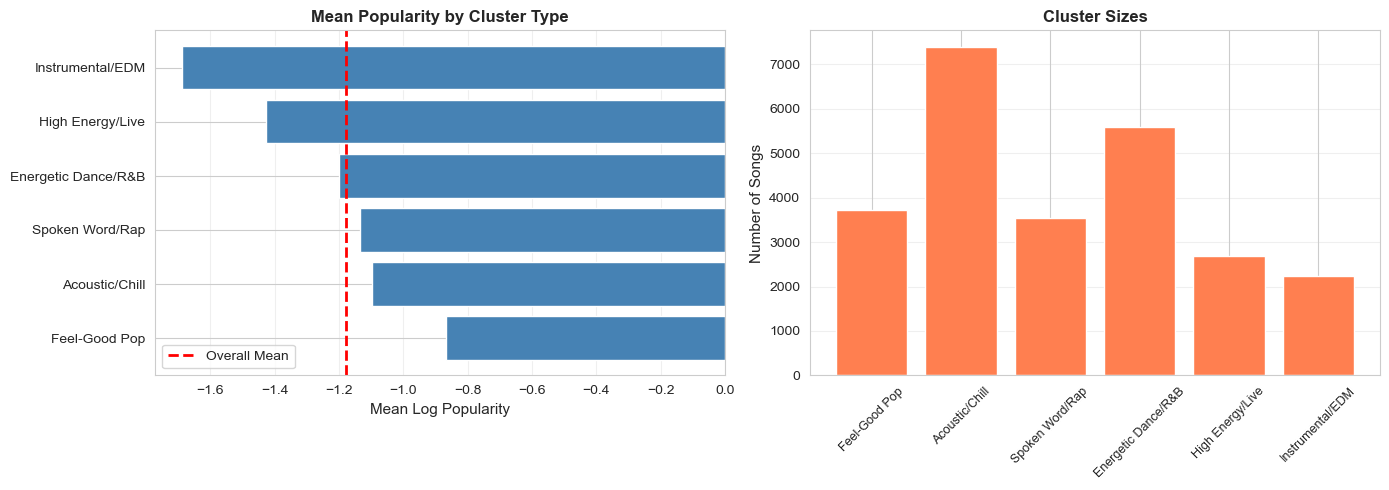

In [16]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].barh(cluster_summary['Description'], cluster_summary['Mean Popularity'], color='steelblue')
axes[0].set_xlabel('Mean Log Popularity', fontsize=11)
axes[0].set_title('Mean Popularity by Cluster Type', fontsize=12, fontweight='bold')
axes[0].axvline(x=log_df['pop_log'].mean(), color='red', linestyle='--', linewidth=2, label='Overall Mean')
axes[0].legend()
axes[0].grid(alpha=0.3, axis='x')

axes[1].bar(cluster_summary['Description'], cluster_summary['Size'], color='coral')
axes[1].set_ylabel('Number of Songs', fontsize=11)
axes[1].set_title('Cluster Sizes', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45, labelsize=9)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Key Findings

### Summary of Clustering Analysis

**1. Optimal Clustering:**
- Elbow method suggests k=6 for K-Means
- K-Means produces interpretable clusters based on audio features

**2. Cluster Characteristics:**
- **Cluster 1 (Acoustic/Chill)** has highest mean popularity (-0.85)
- **Cluster 4 (Instrumental/EDM)** has lowest mean popularity (-1.76)
- Difference between highest and lowest: 0.91 on log scale (still modest)

**3. Critical Limitation:**
> **Clusters do NOT strongly predict popularity.** While we can group songs by audio features (energy, acousticness, danceability), these groupings show minimal popularity separation.

**4. Implications:**
- Audio feature similarity ≠ popularity similarity
- Songs can have identical audio profiles but vastly different popularity
- This reinforces findings from EDA: **audio features alone are insufficient**

**5. What's Missing:**
- Artist recognition/follower count
- Marketing budget and campaign effectiveness
- Playlist placement (editorial vs algorithmic)
- Release timing and cultural trends
- Spotify algorithm boosting

**Note:** Hierarchical clustering was also tested but showed similar results to K-Means (no strong popularity prediction). K-Means with k=6 is used for the remainder of this analysis due to clearer interpretation and computational efficiency.

## Next Steps

**Continue to:**
- **[Linear Modeling](03_linear_models.ipynb)** - Quantify predictive power with regression models

**Export cluster assignments**:

In [17]:
log_df[['cluster_k6']].to_csv('../data/cluster_assignments.csv', index=False)

In [18]:
print("✓ Clustering Analysis Complete")

✓ Clustering Analysis Complete
